## How to Train a Convolutional Neural Network (CNN) Optimally


In this notebook we conduct the same investigation for CNNs that we performed in the previous notebook in the context of dense DNNs. More specifically, our goal is to determine optimal choices for the following three factors that achieve both effectiveness (high test accuracy) and efficiency (faster convergence) in training CNNs.

- Weight initializer
- Activation function
- Learning rate setting technique


## DNN Architecture 
We create a 4 hidden layer based CNN followed by one dense layer and final output layer.
- In all experiments we train the CNN for 100 fixed epochs. We don't use early stopping for the convenience of comparison.
- We use increasing dropout rate for the four hidden layers: 0.2, 0.3, 0.4, 0.5.

## Dataset
We use the CIFAR10 dataset that we used in the previous notebook.


## Experiments

We perform following experiments.

- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam (lr=0.001)
         -- b) He initializer + ELU activation + 1cycle Learning Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Schedule
      -- b) NAdam (lr=0.001)

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Schedule

        These experiments are conducted on a GPU from Google Colaboratory.




In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Check whether a GPU is added
tf.test.gpu_device_name()

'/device:GPU:0'

## Load and Scale the Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]

X_test = X_test/255.0

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)

170500096/170498071 [==============================] - 11s 0us/step

Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float32
Label type:  uint8


## Display a Set of Images

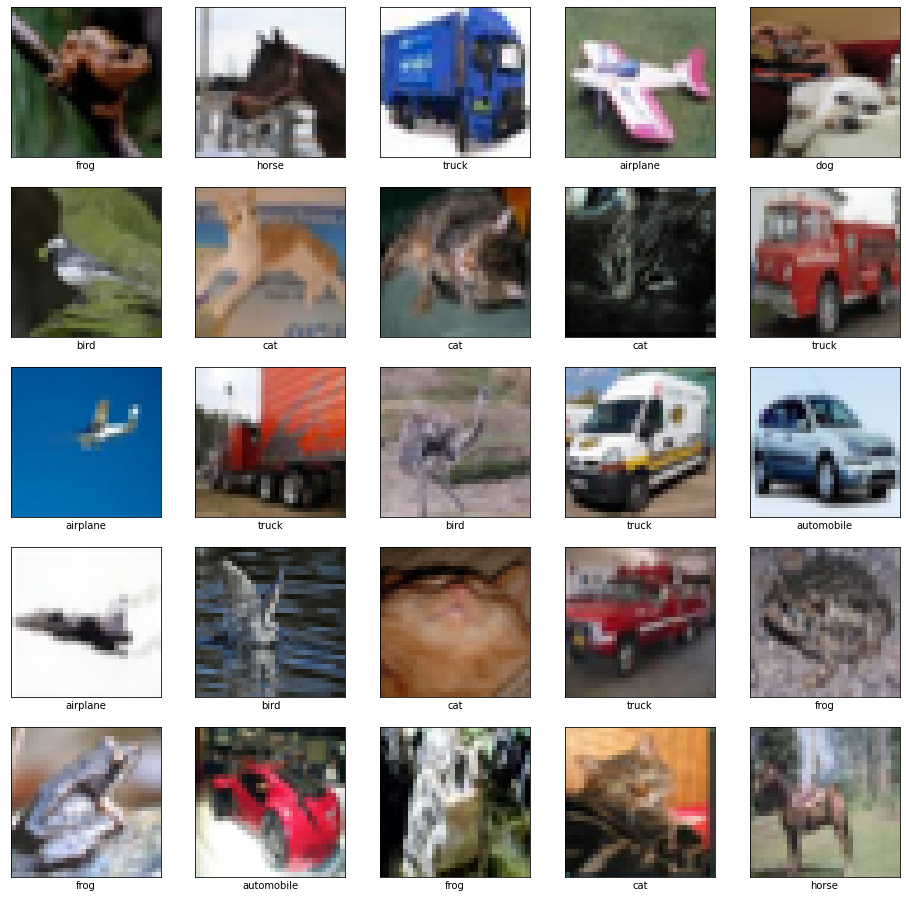

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(16,16))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, that's why we use the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## FUnctions for Various Learning Curves & Converting Training Time

In [5]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
    
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

    
'''
Function to Convert Seconds into Hours, Minutes and Seconds
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [6]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Class for 1cycle Learning Schedule

In [55]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Function for Increasing Learning Rate

In [56]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

## Experiment 1 (a): Batch Normalization

He initializer + ELU activation + NAdam optimizer (lr=0.001)

In [7]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=0.001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_CNN_He_ELU_VarDrop_BN"
model_name_format = "CIFAR10_CNN_He_ELU_VarDrop_BN.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 64
t0 = time.time()
history_CNN_He_ELU_VarDrop_BN = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_He_ELU_VarDrop_BN_sec = t1-t0
duration_CNN_He_ELU_VarDrop_BN = convertTime(duration_CNN_He_ELU_VarDrop_BN_sec)
print("\nTraining Time: ", duration_CNN_He_ELU_VarDrop_BN)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 30s 43ms/step - loss: 1.6087 - accuracy: 0.4566 - val_loss: 1.2249 - val_accuracy: 0.5804
Epoch 2/100
704/704 [==============================] - 29s 42ms/step - loss: 1.0798 - accuracy: 0.6187 - val_loss: 0.9450 - val_accuracy: 0.6634
Epoch 3/100
704/704 [==============================] - 29s 42ms/step - loss: 0.9191 - accuracy: 0.6779 - val_loss: 0.7594 - val_accuracy: 0.7358
Epoch 4/100
704/704 [==============================] - 29s 41ms/step - loss: 0.8178 - accuracy: 0.7157 - val_loss: 0.7461 - val_accuracy: 0.7410
Epoch 5/100
704/704 [==============================] - 29s 42ms/step - loss: 0.7435 - accuracy: 0.7406 - val_loss: 0.6963 - val_accuracy: 0.7598
Epoch 6/100
704/704 [==============================] - 29s 42ms/step - loss: 0.6879 - accuracy: 0.7619 - val_loss: 0.6122 - val_accuracy: 0.7870
Epoch 7/100
704/704 [==============================] - 29s 41ms/step - loss: 0.6307 - accuracy: 0.7829 - val_loss: 0.7662 - val_ac

Epochs:  100

CIFAR10_CNN_He_ELU_VarDrop_BN Test Accuracy: 0.868
CIFAR10_CNN_He_ELU_VarDrop_BN Test Loss: 0.524

Test Confusion Matrix:
[[863  10  24   6   6   4   4   4  39  40]
 [  4 919   0   1   2   0   2   0  10  62]
 [ 35   1 805  30  35  38  31  10   5  10]
 [ 11   2  38 735  25 117  40  12   6  14]
 [  4   0  51  28 845  27  20  21   3   1]
 [  4   2  23  95  13 829   9  20   0   5]
 [  4   2  23  30   7  12 914   3   2   3]
 [  4   0  13  20  19  40   3 896   0   5]
 [ 25   9   6   4   0   3   1   0 932  20]
 [  4  32   3   3   0   2   2   1  10 943]]


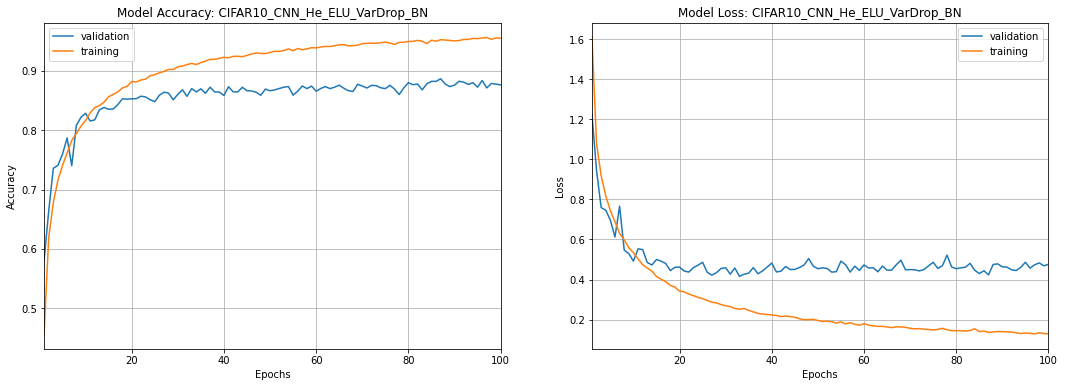

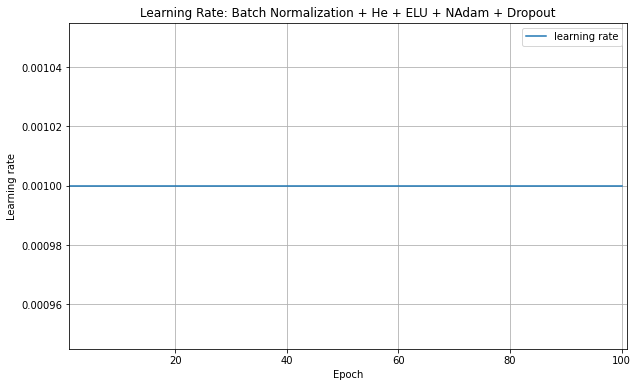

In [8]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_ELU_VarDropout_BN.h5")

numOfEpochs_CNN_He_ELU_VarDrop_BN = len(history_CNN_He_ELU_VarDrop_BN.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_ELU_VarDrop_BN)

test_loss_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_ELU_VarDrop_BN))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_ELU_VarDrop_BN))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                   "Learning Rate: Batch Normalization + He + ELU + NAdam + Dropout", momentumPlot=False)

## Expriment 1(b): Batch Normalization

Instead of using the NAdam optimizer we use 1cycle learning rate schedule with He initializer and ELU activation.


### Find Maximum Learning Rate for 1cycle Schedule

In [57]:

%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

142/142 [==============================] - 5s 33ms/step - loss: 1.8620 - accuracy: 0.5356 - val_loss: 3.0288 - val_accuracy: 0.7658
CPU times: user 5.09 s, sys: 771 ms, total: 5.87 s
Wall time: 6.56 s


## Learning rate vs Loss Plot

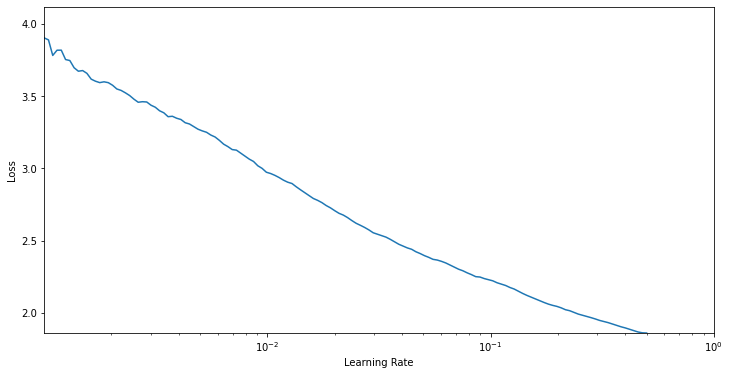

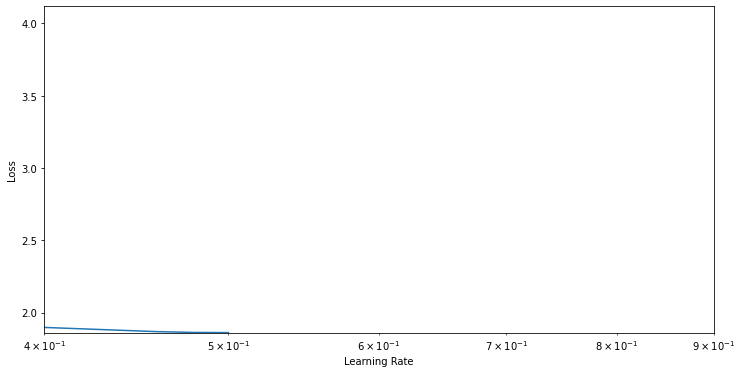

In [61]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.4, 0.9)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Max Learning Rate for 1cycle Schedule

From the above plot we see that the max learning rate is 0.5 at which los is minimum.

In [62]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_BN_1cycle"
model_name_format = "CIFAR10_CNN_BN_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.5, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_BN_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_BN_1cycle_sec = t1-t0
duration_CNN_BN_1cycle = convertTime(duration_CNN_BN_1cycle_sec)
print("\nTraining Time: ", duration_CNN_BN_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 33ms/step - loss: 1.6226 - accuracy: 0.4282 - val_loss: 1.5655 - val_accuracy: 0.4368
Epoch 2/100
704/704 [==============================] - 23s 32ms/step - loss: 1.2254 - accuracy: 0.5596 - val_loss: 1.2238 - val_accuracy: 0.5660
Epoch 3/100
704/704 [==============================] - 23s 33ms/step - loss: 1.0727 - accuracy: 0.6179 - val_loss: 1.4260 - val_accuracy: 0.5340
Epoch 4/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9804 - accuracy: 0.6564 - val_loss: 0.9812 - val_accuracy: 0.6560
Epoch 5/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9026 - accuracy: 0.6815 - val_loss: 1.2795 - val_accuracy: 0.5970
Epoch 6/100
704/704 [==============================] - 23s 32ms/step - loss: 0.8498 - accuracy: 0.7026 - val_loss: 1.0764 - val_accuracy: 0.6318
Epoch 7/100
704/704 [==============================] - 23s 32ms/step - loss: 0.8013 - accuracy: 0.7198 - val_loss: 0.9076 - val_ac

Epochs:  100

CIFAR10_CNN_BN_1cycle Test Accuracy: 0.876
CIFAR10_CNN_BN_1cycle Test Loss: 0.510

Test Confusion Matrix:
[[889  11  13  13  11   1   4   5  36  17]
 [  4 937   2   1   1   3   3   0  15  34]
 [ 29   0 805  49  36  33  30  10   6   2]
 [ 11   2  25 783  29 102  26  15   4   3]
 [  6   0  30  46 856  18  21  18   5   0]
 [  5   1  15 112  22 816   7  21   0   1]
 [  4   0  16  32  12   9 915   6   3   3]
 [  4   1  10  33  23  33   2 890   1   3]
 [ 25   9   3   4   0   2   4   0 939  14]
 [  5  40   2   2   1   2   4   2  11 931]]


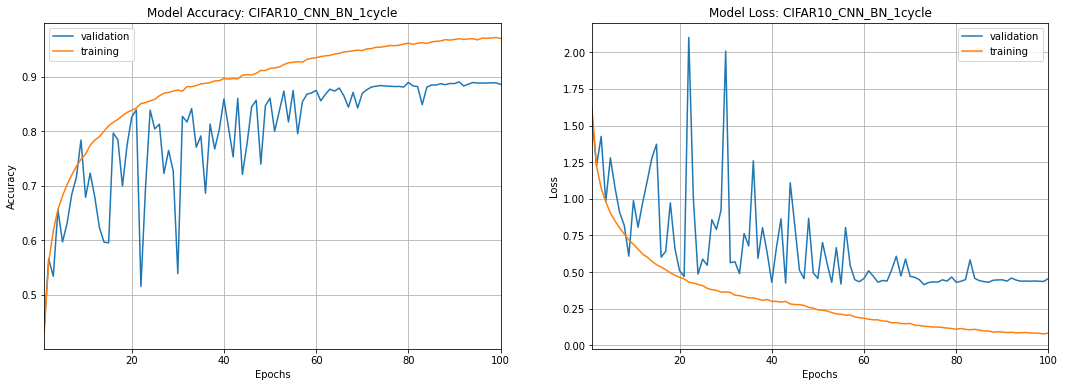

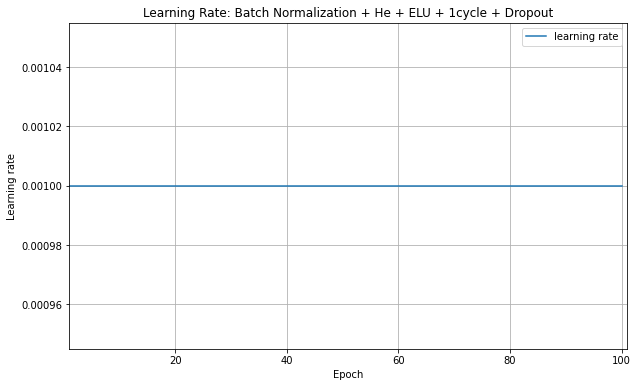

In [63]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_BN_1cycle.h5")

numOfEpochs_CNN_BN_1cycle = len(history_CNN_BN_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_BN_1cycle)

test_loss_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_BN_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_BN_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_BN_1cycle, numOfEpochs_CNN_BN_1cycle, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_BN_1cycle, 
                   "Learning Rate: Batch Normalization + He + ELU + 1cycle + Dropout", momentumPlot=False)

## Experiment 2: Pretraining based Weight Initialization


In this experiment we initialize the weights of the CNN via pretraining. We use a small subset of the training data (with only 2 classes) to train the CNN architecture. Then, using the pretrained layers (except the last two hidden layers and the final layer) as initial weights, we train the CNN using full training data. There are two steps in this pretraining based initialization approach:

- Step 1: Initialize weights by pretraining using a smaller training data
- Step 2: Fine-tune using full training data

For the pretraining part, we use the orthogonal weight initializer and ELU activation function. The model is regularized by using increasing dropout rate in the 4 hidden layers: 0.2, 0.3, 0.4 and 0.5. We pretrain the model for 10 fixed epochs. Within 10 epochs the validation accuracy reaches to 95%.

We set the SGD learning rate using the 1cycle learning schedule. For this, first we find the maximum learning rate. Then, using the maximum learning rate for 1cycle schedule we pretrain the model.

For the fine-tuning, we use the weights of first 2 hidden layers of the pretrained model and add last two hidden layers as well as the output layer. These new layers are initialized using orthogonal weight initializer (2(a)) along with ELU activation. We use the same maximum learning rate for 1cycle learning schedule to train the model for fixed 100 epochs.

In addition to this, we perform another experiment (2(b)) in which we keep the above setting unchanged except the orthogonal initializer is replaced by He initializer.

Thus, there are two pretraining based experiments:
- Experiment 2(a):  Pretraining based Weight Initialization with Orthogonal Initializer

- Experiment 2(b):  Pretraining based Weight Initialization with He Initializer



## Create Small Training & Validation Set
We use 1/5 of the labels to create a smaller training and validation dataset. Effectively the training set is reduced by a factor of 5.

For this experiment, we only use the first two classes for pretraining. For these two classes all training data are used.

In [9]:
'''
Create the smaller training subset
'''

count_few_labels = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        count_few_labels += 1
    

X_train_small = np.zeros((count_few_labels, 32,32,3), 'float32')
y_train_small = np.zeros((count_few_labels, 1), 'uint8')

j = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        X_train_small[j] = X_train[i]
        y_train_small[j] = y_train[i]
        j += 1
        
        
print("\nShape of Small Training Samples: ", X_train_small.shape)
print("Shape of Small Training Labels: ", y_train_small.shape)


Shape of Small Training Samples:  (9035, 32, 32, 3)
Shape of Small Training Labels:  (9035, 1)


In [10]:
'''
Create the smaller validation subset
'''

count_few_labels_valid = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        count_few_labels_valid += 1
    

X_valid_small = np.zeros((count_few_labels_valid, 32,32,3), 'float64')

y_valid_small = np.zeros((count_few_labels_valid, 1), 'uint8')

j = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        X_valid_small[j] = X_valid[i]
        y_valid_small[j] = y_valid[i]
        j += 1
        
        
print("\nShape of Small Validation Samples: ", X_valid_small.shape)
print("Shape of Small Validation Labels: ", y_valid_small.shape)


Shape of Small Validation Samples:  (965, 32, 32, 3)
Shape of Small Validation Labels:  (965, 1)


## Experiment 2(a): Weight Initialization by Pretraining using Orthogonal Initializer


##### Find Maximum Learning Rate for 1cycle Schedule

In [12]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'

model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

142/142 [==============================] - 4s 29ms/step - loss: nan - accuracy: 0.5134 - val_loss: nan - val_accuracy: 0.5233
CPU times: user 3.8 s, sys: 794 ms, total: 4.59 s
Wall time: 5.14 s


## Loss vs Learning Rate Plot

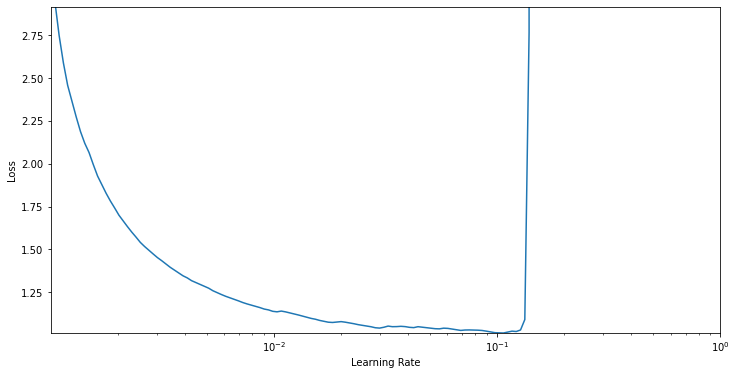

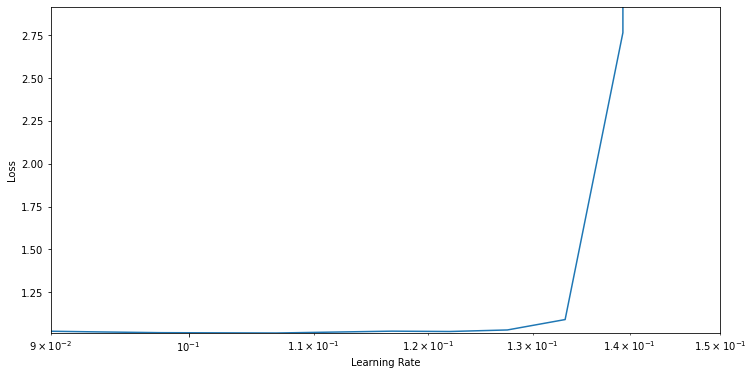

In [14]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.09, 0.15)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## 1cycle Max Learning Rate

We see from the above plot that loss starts increasing after 0.09 learning rate. Thus, we use 0.075 as the maximum learning rate for 1cycle schedule.



## Experiment 2(a) Weight Initialization by Pretraining (Orthogonal Initializer)

In [19]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.075, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_Orthogonal = model_pretrained.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_Orthogonal_sec = t1-t0
duration_Pretraining_1cycle_Orthogonal = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_Orthogonal)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
283/283 [==============================] - 6s 21ms/step - loss: 0.6241 - accuracy: 0.7005 - val_loss: 0.3468 - val_accuracy: 0.8601
Epoch 2/10
283/283 [==============================] - 5s 19ms/step - loss: 0.3918 - accuracy: 0.8317 - val_loss: 0.2676 - val_accuracy: 0.8984
Epoch 3/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2905 - accuracy: 0.8799 - val_loss: 0.3540 - val_accuracy: 0.8446
Epoch 4/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2343 - accuracy: 0.9059 - val_loss: 0.1774 - val_accuracy: 0.9285
Epoch 5/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2014 - accuracy: 0.9205 - val_loss: 0.1453 - val_accuracy: 0.9389
Epoch 6/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1548 - accuracy: 0.9439 - val_loss: 0.1351 - val_accuracy: 0.9472
Epoch 7/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1224 - accuracy: 0.9537 - val_loss: 0.1195 - val_accuracy: 0.9503

## Experiment 2(a): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [21]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(a): Fine-Tune the Pretrained Model with Full Training Data

In [22]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.075, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_Orthogonal = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_Orthogonal_sec = t1-t0
duration_CNN_FineTuning_1cycle_Orthogonal = convertTime(duration_CNN_FineTuning_1cycle_Orthogonal_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_Orthogonal)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 27ms/step - loss: 1.6776 - accuracy: 0.3932 - val_loss: 1.4901 - val_accuracy: 0.4428
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.3485 - accuracy: 0.5186 - val_loss: 1.1508 - val_accuracy: 0.5898
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.2224 - accuracy: 0.5678 - val_loss: 1.1212 - val_accuracy: 0.6196
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1460 - accuracy: 0.5971 - val_loss: 1.0487 - val_accuracy: 0.6276
Epoch 5/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0834 - accuracy: 0.6193 - val_loss: 1.0407 - val_accuracy: 0.6422
Epoch 6/100
704/704 [==============================] - 20s 28ms/step - loss: 1.0304 - accuracy: 0.6407 - val_loss: 1.0212 - val_accuracy: 0.6484
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 0.9839 - accuracy: 0.6562 - val_loss: 2.5704 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Accuracy: 0.869
CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Loss: 0.530

Test Confusion Matrix:
[[860   8  32  15   8   2   3   9  36  27]
 [  7 937   0   0   2   2   4   0  11  37]
 [ 32   1 809  20  42  44  30  14   6   2]
 [ 11   3  33 700  39 142  36  17  10   9]
 [  4   1  30  26 879  14  15  23   6   2]
 [  4   3  21  96  25 819   9  19   2   2]
 [  3   2  16  27  14  11 919   5   1   2]
 [  4   1   8  18  25  30   2 906   1   5]
 [ 23   8   6   5   2   3   2   2 938  11]
 [ 14  37   3   4   0   1   2   1  12 926]]


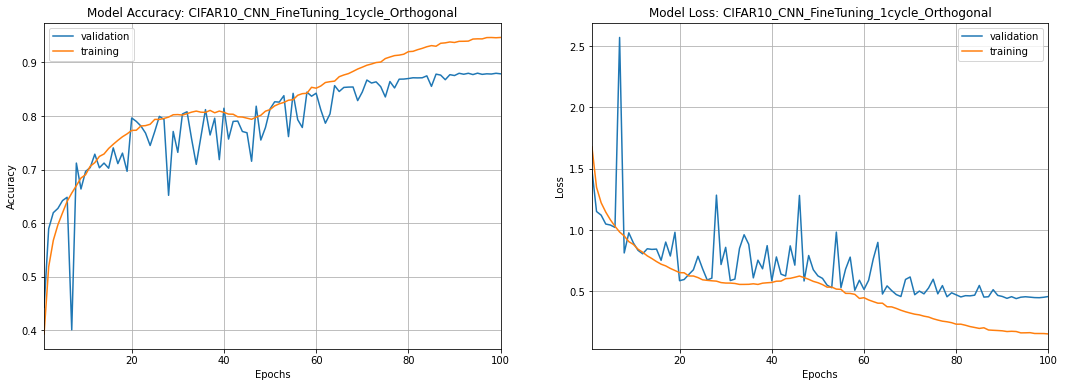

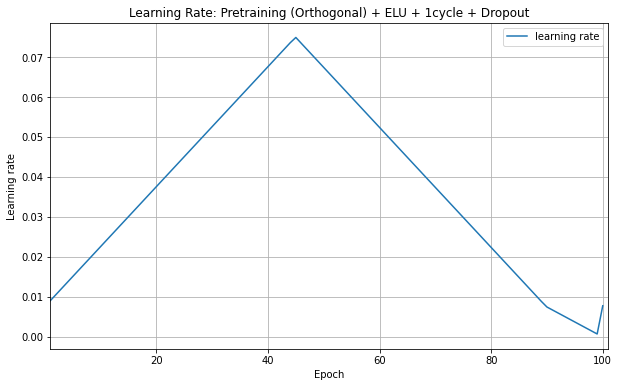

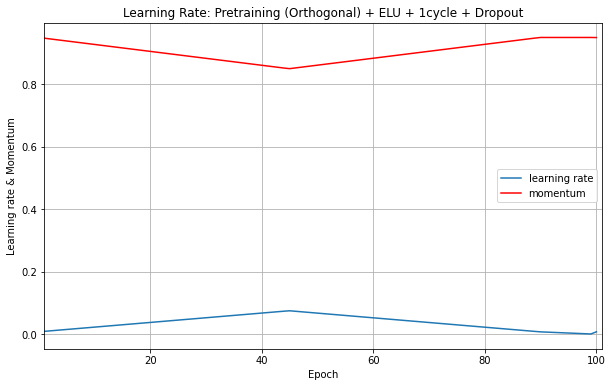

In [23]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5")

numOfEpochs_CNN_FineTuning_1cycle_Orthogonal = len(history_CNN_FineTuning_1cycle_Orthogonal.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal)

test_loss_CNN_FineTuning_1cycle_Orthogonal, test_accuracy_CNN_FineTuning_1cycle_Orthogonal = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_Orthogonal))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_Orthogonal))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_Orthogonal, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 2(b): Weight Initialization by Pretraining using He Initializer

#### Find Maximum Learning Rate for 1cycle Schedule

In [24]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

142/142 [==============================] - 4s 27ms/step - loss: nan - accuracy: 0.5113 - val_loss: nan - val_accuracy: 0.5233
CPU times: user 3.51 s, sys: 670 ms, total: 4.18 s
Wall time: 4.69 s


## Experiment 2(b): Loss vs Learning Rate Plot

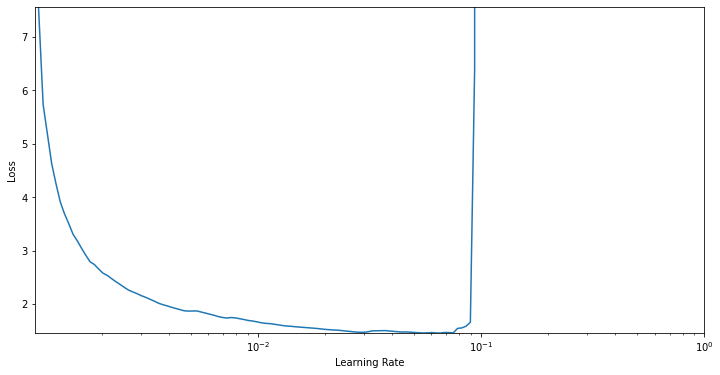

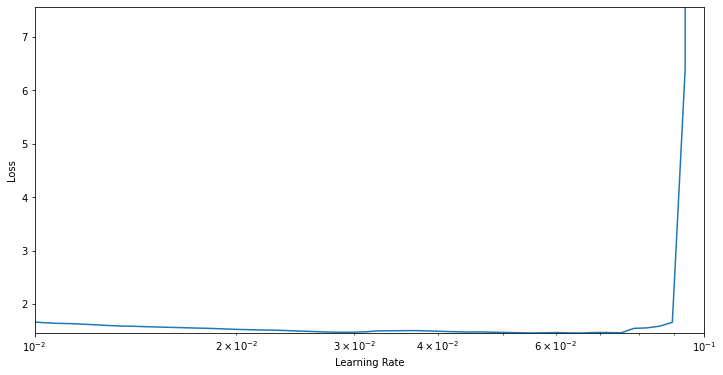

In [25]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.01, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 2(b): 1cycle Max Learning Rate

We see from the above plot that loss starts increasing after 0.07 learning rate. Thus, we use 0.065 as the maximum learning rate for 1cycle schedule.




## Experiment 2(b) Weight Initialization by Pretraining (He Initializer)

In [26]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'

model_pretrained_He = Sequential()
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.2))

model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.3))

model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.4))

model_pretrained_He.add(Flatten())
model_pretrained_He.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained_He.add(Dropout(0.5))
model_pretrained_He.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained_He.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_He"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.07, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_He = model_pretrained_He.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_He_sec = t1-t0
duration_Pretraining_1cycle_He = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_He)
print("\n")


model_pretrained_He.save(model_name_format)

Epoch 1/10
283/283 [==============================] - 6s 20ms/step - loss: 0.7160 - accuracy: 0.7192 - val_loss: 0.2860 - val_accuracy: 0.8850
Epoch 2/10
283/283 [==============================] - 6s 20ms/step - loss: 0.3961 - accuracy: 0.8260 - val_loss: 0.2368 - val_accuracy: 0.9078
Epoch 3/10
283/283 [==============================] - 5s 19ms/step - loss: 0.3107 - accuracy: 0.8752 - val_loss: 0.2580 - val_accuracy: 0.8922
Epoch 4/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2473 - accuracy: 0.9039 - val_loss: 0.2234 - val_accuracy: 0.9026
Epoch 5/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2231 - accuracy: 0.9181 - val_loss: 0.1379 - val_accuracy: 0.9461
Epoch 6/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1633 - accuracy: 0.9380 - val_loss: 0.1246 - val_accuracy: 0.9482
Epoch 7/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1302 - accuracy: 0.9513 - val_loss: 0.1154 - val_accuracy: 0.9482

## Experiment 2(b): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [27]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_He.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_He = keras.models.clone_model(model_pretrained_He)
model_pretrained_clone_He.set_weights(model_pretrained_He.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained_He.layers))

model_pretrained_clone_He.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained_He.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


initializer = 'he_normal'


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(b): Fine-Tune the Pretrained Model with Full Training Data

In [28]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_He"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.07, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_He = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_He_sec = t1-t0
duration_CNN_FineTuning_1cycle_He = convertTime(duration_CNN_FineTuning_1cycle_He_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_He)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 28ms/step - loss: 1.9027 - accuracy: 0.3570 - val_loss: 1.9861 - val_accuracy: 0.3392
Epoch 2/100
704/704 [==============================] - 19s 27ms/step - loss: 1.4246 - accuracy: 0.4968 - val_loss: 1.3333 - val_accuracy: 0.5240
Epoch 3/100
704/704 [==============================] - 19s 27ms/step - loss: 1.2656 - accuracy: 0.5529 - val_loss: 1.1489 - val_accuracy: 0.6046
Epoch 4/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1722 - accuracy: 0.5853 - val_loss: 1.2084 - val_accuracy: 0.5728
Epoch 5/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1052 - accuracy: 0.6086 - val_loss: 1.2464 - val_accuracy: 0.5644
Epoch 6/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0573 - accuracy: 0.6269 - val_loss: 0.9671 - val_accuracy: 0.6600
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 1.0168 - accuracy: 0.6418 - val_loss: 2.2410 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_He Test Accuracy: 0.869
CIFAR10_CNN_FineTuning_1cycle_He Test Loss: 0.520

Test Confusion Matrix:
[[863  10  30  12  10   2   4   5  41  23]
 [  4 929   1   2   2   1   4   0  10  47]
 [ 29   0 810  29  50  32  31  11   5   3]
 [ 10   2  34 736  48  98  42  13   7  10]
 [  7   2  22  22 893  20  17  14   3   0]
 [  5   1  18 129  30 788   8  20   0   1]
 [  2   1  14  33  20  10 916   2   2   0]
 [  5   0  16  29  29  28   2 884   1   6]
 [ 25   6   3   5   3   0   4   1 937  16]
 [  7  35   2   4   1   1   2   1  14 933]]


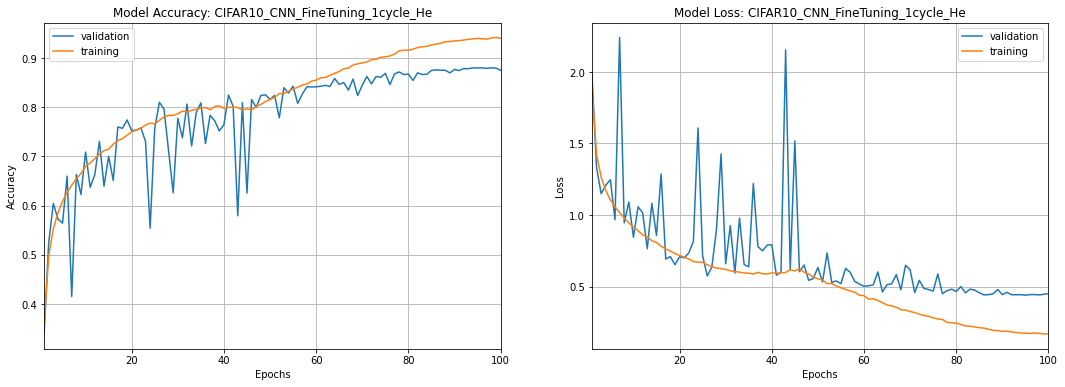

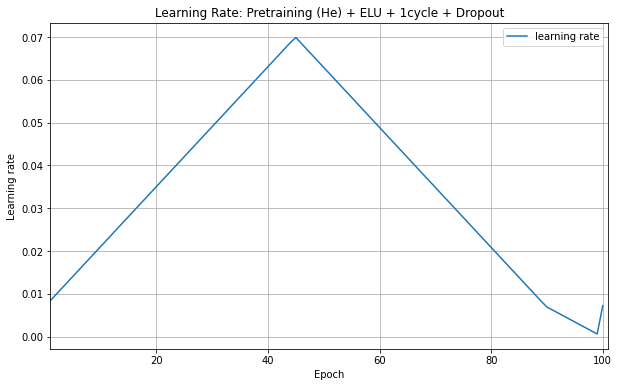

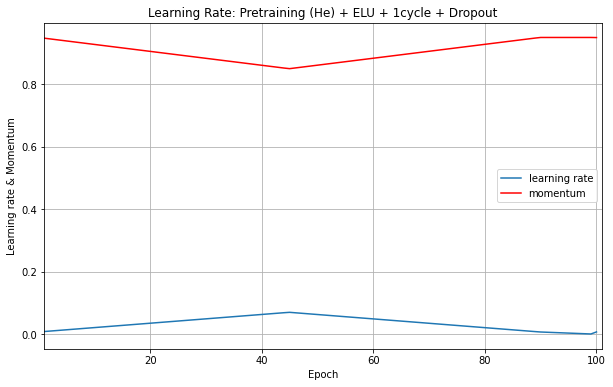

In [29]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_He.h5")

numOfEpochs_CNN_FineTuning_1cycle_He = len(history_CNN_FineTuning_1cycle_He.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_He)

test_loss_CNN_FineTuning_1cycle_He, test_accuracy_CNN_FineTuning_1cycle_He = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_He))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_He))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_FineTuning_1cycle_He, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3 (a): Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [30]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 19s 27ms/step - loss: nan - accuracy: 0.1697 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 14.1 s, sys: 3.41 s, total: 17.5 s
Wall time: 20 s


## Experiment 3: Loss vs Learning Rate Plot

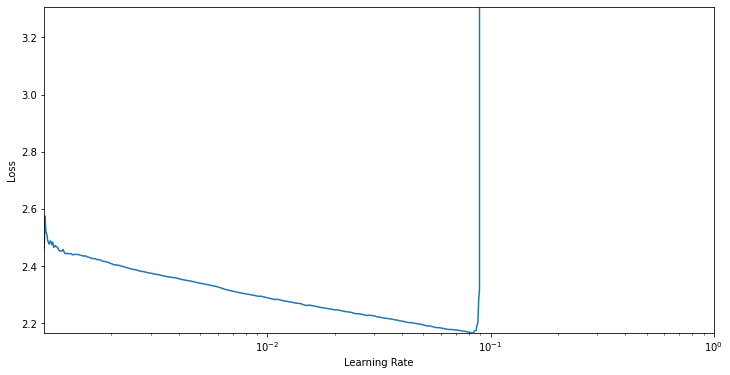

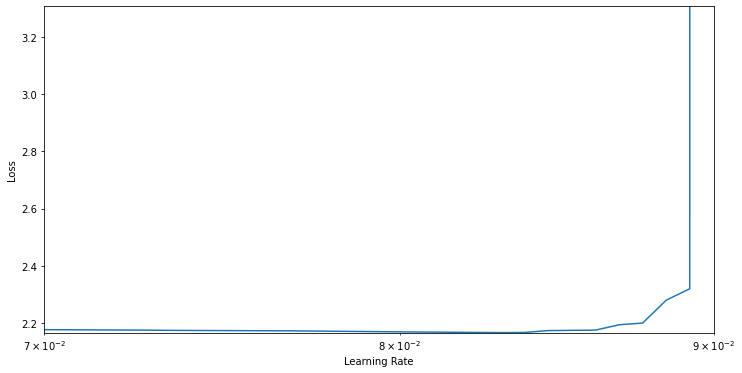

In [36]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.07, 0.09)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 3 (a): 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.08 learning rate. Thus, we use 0.07 as the maximum learning rate for 1cycle schedule.

## Experiment 3 (a): Train the CNN using 1cycle Learning Schedule

In [37]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Orthogonal_1cycle"
model_name_format = "CIFAR10_CNN_Orthogonal_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.83, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_Orthogonal_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_Orthogonal_1cycle_sec = t1-t0
duration_CNN_Orthogonal_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 33ms/step - loss: 1.5205 - accuracy: 0.4636 - val_loss: 1.6360 - val_accuracy: 0.4642
Epoch 2/100
704/704 [==============================] - 23s 33ms/step - loss: 1.1031 - accuracy: 0.6083 - val_loss: 2.5407 - val_accuracy: 0.3318
Epoch 3/100
704/704 [==============================] - 23s 33ms/step - loss: 0.9581 - accuracy: 0.6643 - val_loss: 0.9563 - val_accuracy: 0.6552
Epoch 4/100
704/704 [==============================] - 23s 33ms/step - loss: 0.8688 - accuracy: 0.6967 - val_loss: 1.2399 - val_accuracy: 0.5824
Epoch 5/100
704/704 [==============================] - 23s 33ms/step - loss: 0.8009 - accuracy: 0.7208 - val_loss: 0.8741 - val_accuracy: 0.6950
Epoch 6/100
704/704 [==============================] - 23s 33ms/step - loss: 0.7414 - accuracy: 0.7427 - val_loss: 0.8558 - val_accuracy: 0.7152
Epoch 7/100
704/704 [==============================] - 23s 33ms/step - loss: 0.6925 - accuracy: 0.7615 - val_loss: 1.1813 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_1cycle Test Accuracy: 0.881
CIFAR10_CNN_Orthogonal_1cycle Test Loss: 0.515

Test Confusion Matrix:
[[879   6  25  12  18   5   6   4  32  13]
 [  4 935   1   4   2   1   3   0   5  45]
 [ 26   0 805  36  45  39  31  11   5   2]
 [  7   1  24 755  36 115  37  15   5   5]
 [  4   0  28  19 898  17  12  20   2   0]
 [  4   0  17  83  19 847   9  21   0   0]
 [  3   1  19  32  11  12 915   4   1   2]
 [  7   0   8  24  23  29   4 901   1   3]
 [ 28  11   5   8   1   2   2   2 935   6]
 [  7  29   2   1   2   4   3   3  13 936]]


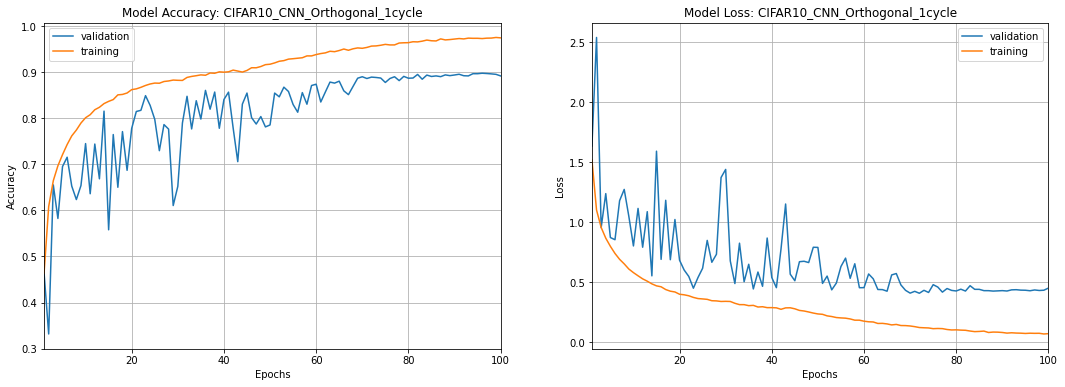

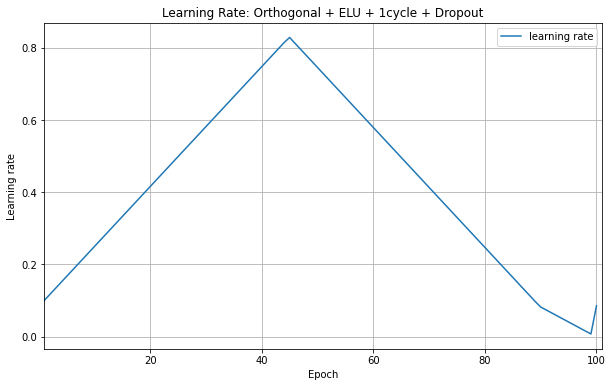

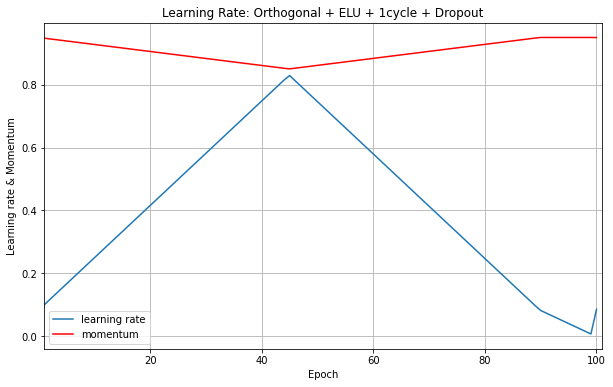

In [38]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_1cycle.h5")

numOfEpochs_CNN_Orthogonal_1cycle = len(history_CNN_Orthogonal_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_1cycle, test_accuracy_CNN_Orthogonal_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_1cycle, numOfEpochs_CNN_Orthogonal_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3(b): Orthogonal + ELU + NAdam (0.001)

In this experiment we only replace the 1cycle schedule on the previous experiment with the NAdam optimizer.

In [69]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "CIFAR10_CNN_Orthogonal_Nadam"
model_name_format = "CIFAR10_CNN_Orthogonal_Nadam.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_CNN_Orthogonal_Nadam = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_Orthogonal_Nadam_sec = t1-t0
duration_CNN_Orthogonal_Nadam = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_Nadam)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 30s 42ms/step - loss: 1.5816 - accuracy: 0.4620 - val_loss: 1.3269 - val_accuracy: 0.5636
Epoch 2/100
704/704 [==============================] - 29s 41ms/step - loss: 1.0421 - accuracy: 0.6326 - val_loss: 0.9312 - val_accuracy: 0.6698
Epoch 3/100
704/704 [==============================] - 29s 41ms/step - loss: 0.8764 - accuracy: 0.6938 - val_loss: 0.7979 - val_accuracy: 0.7252
Epoch 4/100
704/704 [==============================] - 29s 41ms/step - loss: 0.7802 - accuracy: 0.7294 - val_loss: 0.7254 - val_accuracy: 0.7478
Epoch 5/100
704/704 [==============================] - 29s 41ms/step - loss: 0.7088 - accuracy: 0.7541 - val_loss: 0.6067 - val_accuracy: 0.7922
Epoch 6/100
704/704 [==============================] - 29s 41ms/step - loss: 0.6549 - accuracy: 0.7733 - val_loss: 0.5896 - val_accuracy: 0.7964
Epoch 7/100
704/704 [==============================] - 29s 41ms/step - loss: 0.6012 - accuracy: 0.7927 - val_loss: 0.9151 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_Nadam Test Accuracy: 0.871
CIFAR10_CNN_Orthogonal_Nadam Test Loss: 0.512

Test Confusion Matrix:
[[871  11  21  10  10   1   2   8  42  24]
 [  3 960   1   2   0   1   1   0   5  27]
 [ 34   2 810  52  37  30  21   8   2   4]
 [ 10   3  34 760  28 104  30  16   8   7]
 [  8   0  38  34 838  27  22  24   9   0]
 [  5   1  13 116  19 818   1  23   2   2]
 [  4   3  28  36   7  15 896   3   6   2]
 [  7   1  12  29  20  34   1 891   1   4]
 [ 24  12   1  10   0   1   1   2 938  11]
 [  9  48   0   5   0   1   2   3   7 925]]


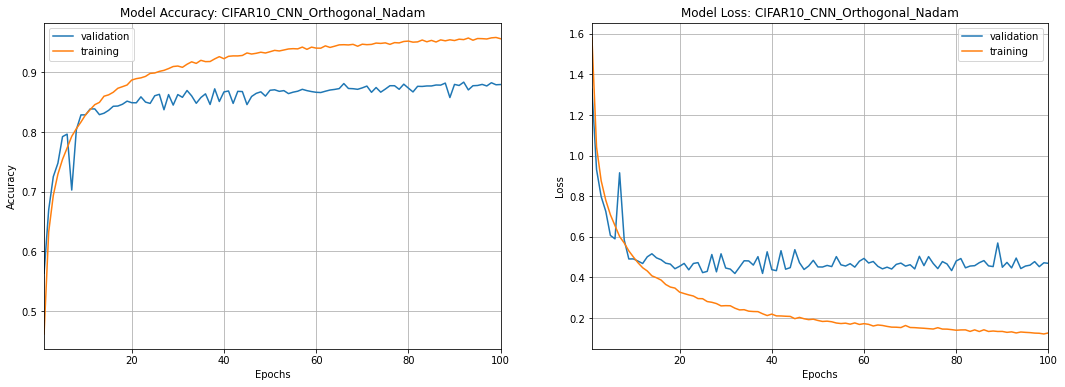

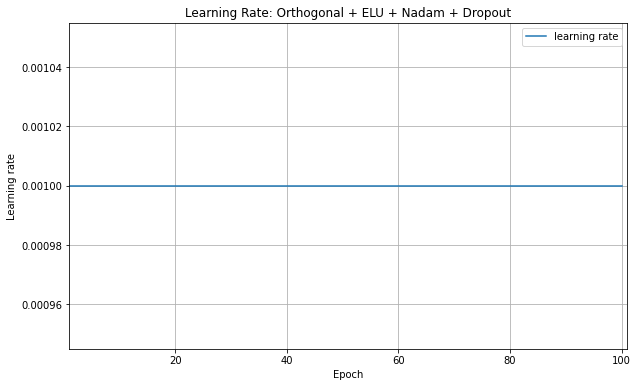

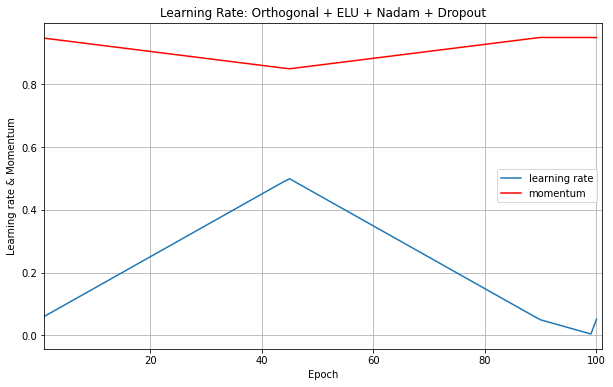

In [70]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_Nadam.h5")

numOfEpochs_CNN_Orthogonal_Nadam = len(history_CNN_Orthogonal_Nadam.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_Nadam, test_accuracy_CNN_Orthogonal_Nadam = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_Nadam))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_Nadam))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_Nadam, numOfEpochs_CNN_Orthogonal_Nadam, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_Orthogonal_Nadam, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=True)

## Experiment 4: He Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [39]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 18s 26ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 13.8 s, sys: 3.27 s, total: 17.1 s
Wall time: 19.6 s


## Experiment 4: Loss vs Learning Rate Plot

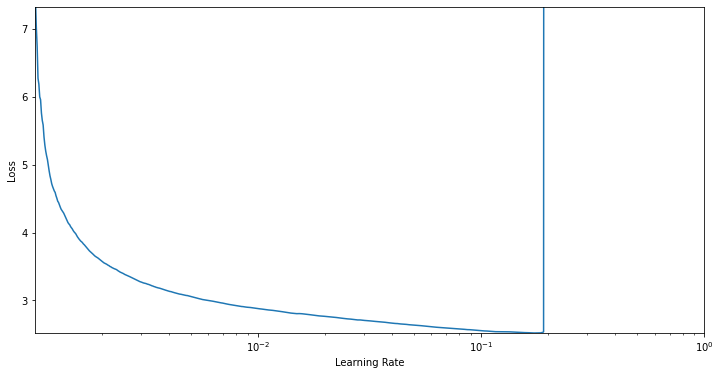

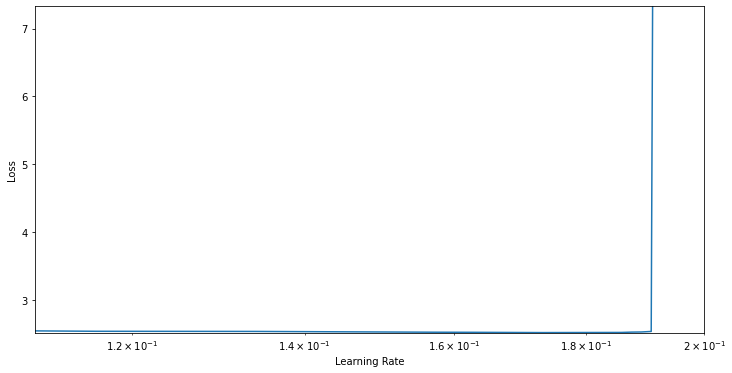

In [41]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.11, 0.2)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 4: 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.08 learning rate. Thus, we use 0.07 as the maximum learning rate for 1cycle schedule.


## Experiment 4: Train the CNN using 1cycle Learning Schedule

In [42]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_He_1cycle"
model_name_format = "CIFAR10_CNN_He_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.17, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_He_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_He_1cycle_sec = t1-t0
duration_CNN_He_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_He_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 33ms/step - loss: 1.8599 - accuracy: 0.3738 - val_loss: 1.4534 - val_accuracy: 0.4902
Epoch 2/100
704/704 [==============================] - 23s 32ms/step - loss: 1.3759 - accuracy: 0.4999 - val_loss: 1.4707 - val_accuracy: 0.4840
Epoch 3/100
704/704 [==============================] - 23s 33ms/step - loss: 1.2226 - accuracy: 0.5613 - val_loss: 1.1539 - val_accuracy: 0.5886
Epoch 4/100
704/704 [==============================] - 23s 33ms/step - loss: 1.1300 - accuracy: 0.5989 - val_loss: 1.1054 - val_accuracy: 0.6072
Epoch 5/100
704/704 [==============================] - 23s 32ms/step - loss: 1.0578 - accuracy: 0.6210 - val_loss: 1.1362 - val_accuracy: 0.6214
Epoch 6/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9959 - accuracy: 0.6482 - val_loss: 0.9280 - val_accuracy: 0.6696
Epoch 7/100
704/704 [==============================] - 23s 32ms/step - loss: 0.9421 - accuracy: 0.6693 - val_loss: 1.3291 - val_ac

Epochs:  100

CIFAR10_CNN_He_1cycle Test Accuracy: 0.877
CIFAR10_CNN_He_1cycle Test Loss: 0.479

Test Confusion Matrix:
[[885   9  23   5   8   0   7   6  30  27]
 [  7 941   0   0   2   2   1   0   6  41]
 [ 34   0 809  31  42  34  30  15   3   2]
 [ 16   4  27 732  33 110  38  20  12   8]
 [  7   1  26  23 892  15  13  17   6   0]
 [  4   2  19  93  27 824   6  23   1   1]
 [  3   2  18  22  13  10 919   6   5   2]
 [  7   0  16  16  25  32   0 903   1   0]
 [ 28  12   2   5   1   2   2   1 932  15]
 [ 13  31   2   3   0   1   3   1  10 936]]


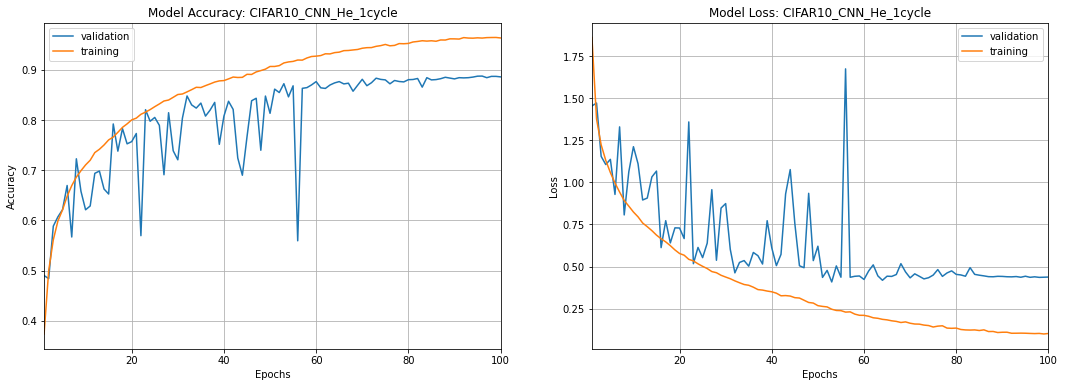

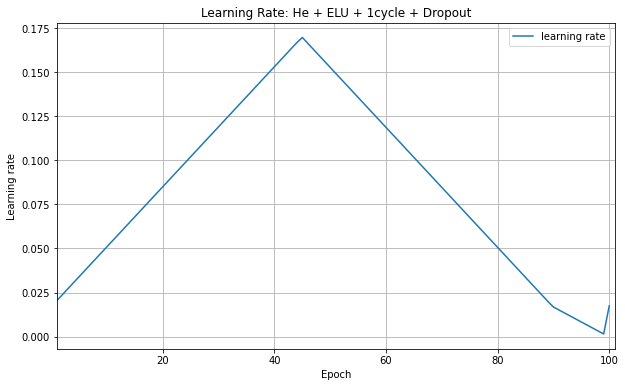

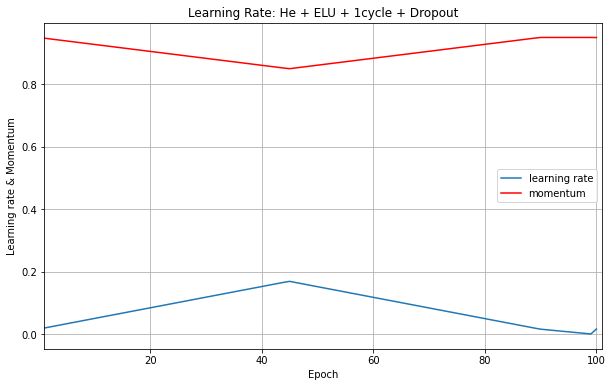

In [43]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_1cycle.h5")

numOfEpochs_CNN_He_1cycle = len(history_CNN_He_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_1cycle)

test_loss_CNN_He_1cycle, test_accuracy_CNN_He_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_1cycle, numOfEpochs_CNN_He_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=True)

## Comparison of Validation Accuracy Over Epochs

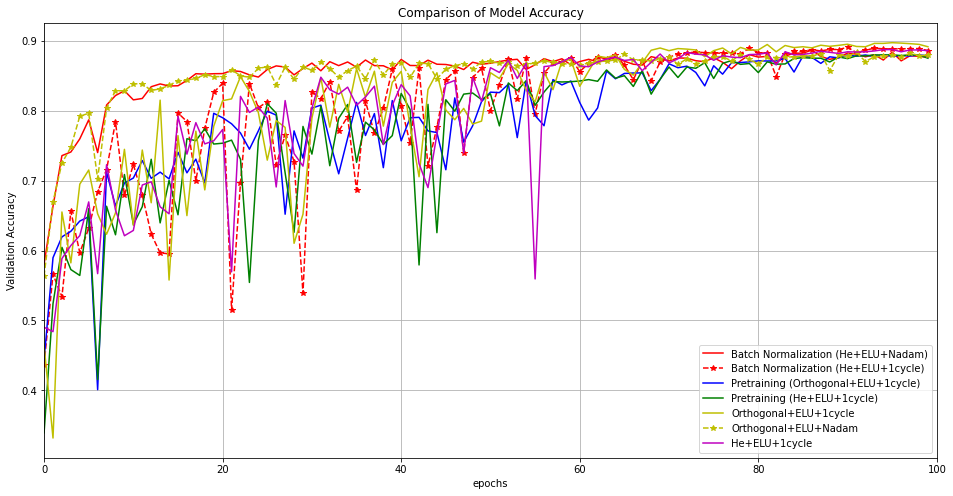

In [71]:
epochs = max(numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_He_1cycle)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_CNN_He_ELU_VarDrop_BN),history_CNN_He_ELU_VarDrop_BN.history['val_accuracy'],'r-',
         label='Batch Normalization (He+ELU+Nadam)')


plt.plot(range(numOfEpochs_CNN_BN_1cycle),history_CNN_BN_1cycle.history['val_accuracy'],'r*--',
         label='Batch Normalization (He+ELU+1cycle)')



plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_Orthogonal),history_CNN_FineTuning_1cycle_Orthogonal.history['val_accuracy'],'b-',
         label='Pretraining (Orthogonal+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_He),history_CNN_FineTuning_1cycle_He.history['val_accuracy'],'g-',
         label='Pretraining (He+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_Orthogonal_1cycle),history_CNN_Orthogonal_1cycle.history['val_accuracy'],'y-',
         label='Orthogonal+ELU+1cycle')

plt.plot(range(numOfEpochs_CNN_Orthogonal_Nadam),history_CNN_Orthogonal_Nadam.history['val_accuracy'],'y*--',
         label='Orthogonal+ELU+Nadam')

plt.plot(range(numOfEpochs_CNN_He_1cycle),history_CNN_He_1cycle.history['val_accuracy'],'m-',
         label='He+ELU+1cycle')



plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [73]:
data = [
    ["1(a): Batch Normalization (Nadam)", numOfEpochs_CNN_He_ELU_VarDrop_BN, duration_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN],
    ["1(b): Batch Normalization (1cycle)", numOfEpochs_CNN_BN_1cycle, duration_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle],
    ["2(a): Pretraining (Orthogonal)", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, duration_CNN_FineTuning_1cycle_Orthogonal, 
     test_accuracy_CNN_FineTuning_1cycle_Orthogonal],
    ["2(b): Pretraining (He)", numOfEpochs_CNN_FineTuning_1cycle_He, duration_CNN_FineTuning_1cycle_He, 
     test_accuracy_CNN_FineTuning_1cycle_He],
    ["3(a): Orthogonal+ELU+1cycle", numOfEpochs_CNN_Orthogonal_1cycle, duration_CNN_Orthogonal_1cycle, 
     test_accuracy_CNN_Orthogonal_1cycle],
    ["3(b): Orthogonal+ELU+Nadam", numOfEpochs_CNN_Orthogonal_Nadam, duration_CNN_Orthogonal_Nadam, 
     test_accuracy_CNN_Orthogonal_Nadam],
    ["4: He+ELU+1cycle", numOfEpochs_CNN_He_1cycle, duration_CNN_He_1cycle, 
     test_accuracy_CNN_He_1cycle]]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,1(a): Batch Normalization (Nadam),100,48 min 54 s,0.8681
1,1(b): Batch Normalization (1cycle),100,37 min 50 s,0.8761
2,2(a): Pretraining (Orthogonal),100,31 min 52 s,0.8693
3,2(b): Pretraining (He),100,31 min 50 s,0.8689
4,3(a): Orthogonal+ELU+1cycle,100,38 min 17 s,0.8806
5,3(b): Orthogonal+ELU+Nadam,100,48 min 21 s,0.8707
6,4: He+ELU+1cycle,100,38 min 5 s,0.8773


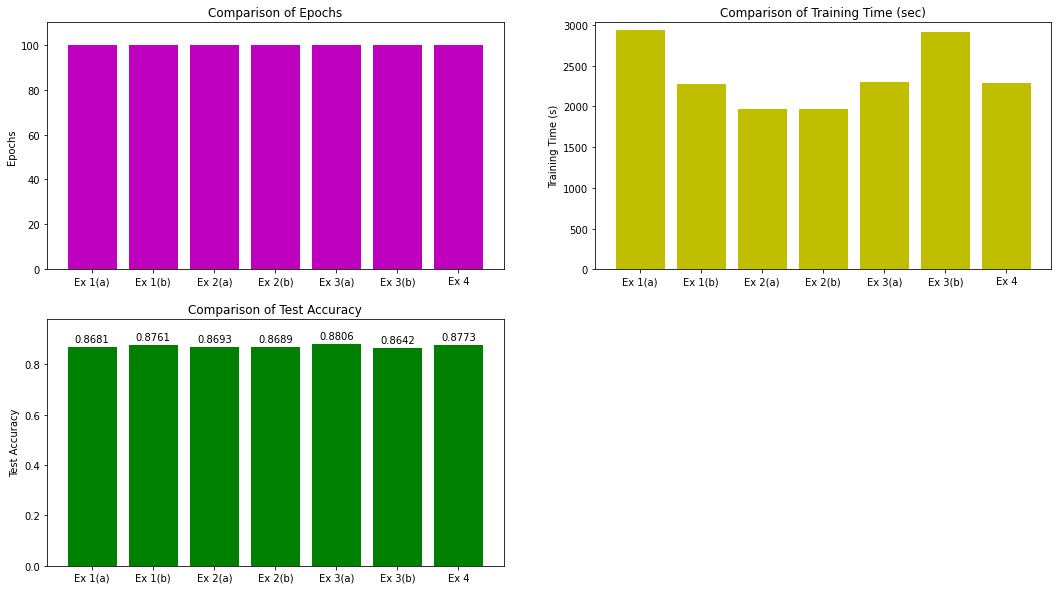

In [68]:
plt.figure(figsize=(18,10))

labels_true = ["Batch Normalization", "Pretraining (Orthogonal)", "Pretraining (He)", 
               "Orthogonal+ELU+1cycle", "He+ELU+1cycle"]


labels = ["Ex 1(a)", "Ex 1(b)", "Ex 2(a)", "Ex 2(b)", "Ex 3(a)", "Ex 3(b)", "Ex 4"]

epochs_num= [numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_BN_1cycle, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_Orthogonal_Nadam, numOfEpochs_CNN_He_1cycle]

duration_num = [duration_CNN_He_ELU_VarDrop_BN_sec, duration_CNN_BN_1cycle_sec,
                (duration_Pretraining_1cycle_Orthogonal_sec+duration_CNN_FineTuning_1cycle_Orthogonal_sec),
                (duration_Pretraining_1cycle_He_sec+duration_CNN_FineTuning_1cycle_He_sec),
                duration_CNN_Orthogonal_1cycle_sec, duration_CNN_Orthogonal_Nadam_sec, duration_CNN_He_1cycle_sec]

test_acc = [test_accuracy_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_BN_1cycle, test_accuracy_CNN_FineTuning_1cycle_Orthogonal,
            test_accuracy_CNN_FineTuning_1cycle_He, test_accuracy_CNN_Orthogonal_1cycle,
            test_accuracy_CNN_Orthogonal_Nadam, test_accuracy_CNN_He_1cycle]


plt.subplot(221)
plt.ylabel("Epochs")
plt.title("Comparison of Epochs")
plt.ylim(0, max(epochs_num)+10)
rects1=plt.bar(labels, epochs_num, color="m")

plt.subplot(222)
plt.ylabel("Training Time (s)")
plt.title("Comparison of Training Time (sec)")
plt.ylim(0, max(duration_num)+100)
rects2=plt.bar(labels, duration_num, color="y")

plt.subplot(223)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy")
plt.ylim(0, max(test_acc)+0.1)
rects3=plt.bar(labels, test_acc, color="g")

     
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects3)

plt.show()

## Comparative Analysis


Below we compare the performance of seven approaches based on the results obtained from the following experiments:


- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam (lr=0.001)
         -- b) He initializer + ELU activation + 1cycle Learning Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Schedule
      -- b) NAdam (lr=0.001)

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Schedule



We observe that the **Orthogonal initializer** along with ELU activation and 1cycle learning schedule (experiment 3a) achieves highest test accuracy (effective). However, its training time is larger than that of the training time of the pretraining based approach.

The **pretraining weight initialization** approach (2a and 2b) is most efficient (shortest training time), and its test accuracy is pretty close to the highest accuracy of Orthogonal initializer.

The **Batch Normalization** based approach is effective and efficient when used with 1cycle learning schedule. But its training time is never smaller than that of Pretraining based approach.


Following are our key recommendations:
- If one must use BN then it should be used with 1cycle learning schedule and fixed epochs.
- If efficiency is more important along with high enough test accuracy, then pretraining based initializer should be used.
- Overall orthogonal initializer performs better, so should be used during pretraining and fine-tuning (for the added layers).

Contrary to the convention of using fast optimizers, we found that a good learning schedule often achieves faster convergence (see 1a and 3b).


Finally, we see that the following choices for the three factors give optimal performance in training CNNs. We had the exact same observation in dense DNNs as well.
- Weight initializer: orthogonal
- Activation: ELU
- SGD learning rate: 1cycle 
